# Importing stuff

In [ ]:
pip install scikit-optimize

     |████████████████████████████████| 100 kB 7.3 MB/s 


In [ ]:
pip install smogn

In [ ]:
import pandas as pd
import numpy as np
import os
import xgboost as xgb
from xgboost import XGBRegressor
import time

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
import imblearn
import smogn

from skopt import BayesSearchCV

from sklearn import preprocessing
from itertools import product
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from collections.abc import Iterable
import math
import random
from scipy.stats import spearmanr, pearsonr
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

pd.options.mode.chained_assignment = None  # default='warn'
!wget https://raw.githubusercontent.com/myprogrammerpersonality/BlackBoxOptimizer/master/Functions_Final_v3_1.py
from Functions_Final_v3_1 import *

np.random.seed(42)
random.seed(42)


Mounted at /content/drive
--2022-03-25 11:22:07--  https://raw.githubusercontent.com/myprogrammerpersonality/BlackBoxOptimizer/master/Functions_Final_v3_1.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22100 (22K) [text/plain]
Saving to: ‘Functions_Final_v3_1.py’

Functions_Final_v3_ 100%[===================>]  21.58K  --.-KB/s    in 0s      

2022-03-25 11:22:07 (81.5 MB/s) - ‘Functions_Final_v3_1.py’ saved [22100/22100]



# Some additional functions

In [ ]:
#objective = 'reg:squarederror'   # reg:squarederror or reg:gamma 

def random_cv_opt(data, labels, param_grid, n_iter, reg_type): 
    RandomCV = True
    if RandomCV:
        # create a XGBoost classifier (dart or default)
        if reg_type != None: 
            model = XGBRegressor(objective = objective, eval_metric = 'mae', booster=reg_type)
        else:
            model = XGBRegressor(objective = objective, eval_metric = 'mae', booster='gbtree')
        # create the grid search object
        grid = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid,
            cv=5,
            random_state=42, 
            scoring= 'neg_mean_absolute_error',
            n_jobs=-1,
            n_iter=n_iter)
        
        print('RandomSearchCV ...')
        grid.fit(data.values, labels.values)
        results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
        if reg_type != None: 
            regressors_list = [XGBRegressor(objective = objective, eval_metric = 'mae', booster=reg_type,**param) for param in results.params.iloc[0:ensemble_len,] ]
        else:
            regressors_list = [XGBRegressor(objective = objective, eval_metric = 'mae', booster='gbtree', **param) for param in results.params.iloc[0:ensemble_len,] ]
        print('RandomSearchCV Done!')

    else:
        if reg_type != None:
            regressors_list = [XGBRegressor(
                objective = objective,
                eval_metric = 'mae',
                booster = reg_type,
                learning_rate = l ,
                max_depth = 6,
                rate_drop = 0.1,
                skip_drop=0.5,
                min_child_weight = 4,
                subsample = 0.9,
                gamma = 0.4,
                colsample_bytree = 0.9) for n in (10, 20, 30, 40, 50) for l in (0.01, 0.03, 0.1, 0.2)]
        else: 
            regressors_list = [XGBRegressor(
                objective = objective,
                eval_metric = 'mae',
                n_estimators = n,
                learning_rate = l ,
                max_depth = 6,
                min_child_weight = 4,
                subsample = 0.9,
                gamma = 0.4,
                colsample_bytree = 0.9) for n in (10, 20, 30, 40, 50) for l in (0.01, 0.03, 0.1, 0.2)]
    
    return(results, regressors_list)

def kfold_better(data, labels, regressors_list, nsplits, reg_type):
    """Kfold validation for the regressor list performance

    Parameters
    ----------
    data : pandas.DataFrame
        all previous day data

    label : pandas.DataFrame
        all previous day label
    
    regressors_list : list
        a list consists of more than one regressor that has .fit and .predict feature

    nsplits : number
        desired number of folds for the kfold algorithm

    reg_type : string
        regressor type: "dart", default=none
        
    Returns
    -------
    mae_test :
        mean absolute error bvalues for the yield values predicted by the regressor list for the test set
    
    r2_test :
        r2 correlation values for the yield values predicted by the regressor list for the test set

    sr_test :
        spearman correlation values for the yield values predicted by the regressor list for the test set

    predictions :
        a list of absolute yield values predicted by the regressor list

    y_test :
        a list with absolute test values produced by random shuffling
    """
    k_fold = KFold(n_splits=nsplits, shuffle=True, random_state=42)
    data = np.array(data)
    labels = np.array(labels)
    maes_test = []
    r2_test = []
    sr_test = []
    for train_indices, test_indices in k_fold.split(data):
        x_train, x_test = data[train_indices], data[test_indices]
        y_train, y_test = labels[train_indices],labels[test_indices]
        mean_reg_test = []
        mean_reg_train = []
        r2_reg_test = []
        r2_reg_train = []
        sr_reg_test = []
        sr_reg_train = []
        predictions = []

        for regressor in regressors_list:
          regressor.fit(x_train, y_train)
          prediction = regressor.predict(x_test)
          predictions.append(prediction) 
        predictions = np.mean(predictions, axis=0)
        
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        sr = spearmanr(y_test, predictions)

        maes_test.append(np.mean(mae))
        r2_test.append(np.mean(r2))
        sr_test.append(np.mean(sr))
    print('Done!')
    return(maes_test,r2_test,sr_test, predictions, y_test)


def kfold_better_separate_val(data, labels, x_val, y_val, regressors_list, nsplits, reg_type):
    """Kfold validation for the regressor list performance, requires a separate validation set created by the user

    Parameters
    ----------
    data : pandas.DataFrame
        all previous day data

    labels : pandas.DataFrame
        all previous day label
    
    x_val : pandas.DataFrame
        validation data set

    y_val : pandas.DataFrame
        validation label set
    
    regressors_list : list
        a list consists of more than one regressor that has .fit and .predict feature

    nsplits : number
        desired number of folds for the kfold algorithm

    reg_type : string
        regressor type: "dart", default=none
        
    Returns
    -------
    mae_test :
        mean absolute error bvalues for the yield values predicted by the regressor list for the validation set
    
    r2_test :
        r2 correlation values for the yield values predicted by the regressor list for the validation set

    sr_test :
        spearman correlation values for the yield values predicted by the regressor list for the validation set

    predictions :
        a list of absolute yield values predicted by the regressor list for the validation set

    y_test :
        a list with absolute validation values
    """
    k_fold = KFold(n_splits=nsplits, shuffle=True, random_state=42)
    data = np.array(data)
    labels = np.array(labels)
    maes_test = []
    r2_test = []
    sr_test = []
    for train_indices, test_indices in k_fold.split(data):
        x_train, x_test = data[train_indices], data[test_indices]
        y_train, y_test = labels[train_indices],labels[test_indices]
        mean_reg_test = []
        mean_reg_train = []
        r2_reg_test = []
        r2_reg_train = []
        sr_reg_test = []
        sr_reg_train = []
        predictions = []

        for regressor in regressors_list:
          regressor.fit(x_train, y_train)
          prediction = regressor.predict(x_val.values)
          predictions.append(prediction) 
        predictions = np.mean(predictions, axis=0)
        
        mae = mean_absolute_error(y_val.values, predictions)
        r2 = r2_score(y_val.values, predictions)
        sr = spearmanr(y_val.values, predictions)

        maes_test.append(np.mean(mae))
        r2_test.append(np.mean(r2))
        sr_test.append(np.mean(sr))
    print('Done!')
    return(maes_test,r2_test,sr_test, predictions, y_val)

def result_preprocess_all(desired_cols, range=995):
    name = 'Efficiency_all_data.csv'
    results = pd.read_csv(name)
    # m number pipeline
    data_m = results[desired_cols].iloc[:range, :]
    label_m = results[['yield']].iloc[:range, :]

    # reference, control and specials
    data_specials = results[desired_cols].iloc[range:, :]
    label_specials = results[['yield']].iloc[range:, :]

    return data_m, label_m, data_specials, label_specials

# Stuff for optimization data

In [ ]:
# General Parameters:
m = 125      # number_of_combination_each_round
minimum_drop_size_nanoliter = 25
final_reaction_volume_nanoliter = 10000
maximum_volume_of_model_output = 9000 # (e.g. volume except fixed parts - 100 nl avoid 0 water)
fixed_parts = {'Substrate':0.1} 
days_total = 9 # how many days you want to continue # set it at your max prediction

# Model Parameters:
RandomCV = True
n_iter = 200
ensemble_len = 20 
exploration = {1: 1.41, 2: 1.41, 3: 1,
               4: 1.0, 5: 0.5, 6: 1.0, 7:0.5, 8:0.5, 9:0.5}
days_range = [m for i in range(days_total)]

# Part 1: choose grid for our metabolite conc and define stock concentration

# it is important to define all value for function to be able to get conc that is appropriate to your minimum drop size
# each metabolite min, max and stock must be in same units

# concentrations_limits :
# *** metabolite name must not includes "_" ***

concentrations_limits = {
  'HEPES':{'Conc_Min':50.0, 'Conc_Max':200.0, 'Conc_Values':[50.0, 75.0, 100.0, 125.0, 150.0, 175.0, 200.0], 'Conc_Stock':1000.0, 'Alternatives':['pH7.0','pH7.2','pH7.4','pH7.6','pH7.8','pH8.0']},
  'MgCl2':{'Conc_Min':0.0, 'Conc_Max':20.0, 'Conc_Values':[0.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.0], 'Conc_Stock':1000.0, 'Alternatives':None},
  'CP':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[0.0, 2.5, 5.0, 10.0, 20.0, 40.0, 60.0], 'Conc_Stock':500.0, 'Alternatives':None},
  'Bicarbonate':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[2.5, 5.0, 10.0, 20.0, 40.0, 60.0, 80.0], 'Conc_Stock':1000.0, 'Alternatives':None},
  'Formate':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[0.0, 2.5, 5.0, 10.0, 20.0, 40.0, 60.0, 80.0], 'Conc_Stock':1000.0, 'Alternatives':None},
  'CoA':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0], 'Conc_Stock':40.0, 'Alternatives':None},
  'B12':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[0.0, 0.1, 0.2, 0.4], 'Conc_Stock':5.0, 'Alternatives':None},
  'ATP':{'Conc_Min':0.5, 'Conc_Max':10.0, 'Conc_Values':None, 'Conc_Stock':400.0, 'Alternatives':None},
  'NADPH':{'Conc_Min':1.0, 'Conc_Max':10.0, 'Conc_Values':None, 'Conc_Stock':500.0, 'Alternatives':None},
  'Pco':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[0.09567500000000001, 0.287025, 0.4783750000000001, 0.9567500000000002, 1.72215 , 2.2962, 3.0616000000000003,  4.01835,  5.357800000000001, 7.175625000000001,  9.5675], 'Conc_Stock':38.27, 'Alternatives':None},
  'Ccr':{'Conc_Min':0.31, 'Conc_Max':3.08, 'Conc_Values':None, 'Conc_Stock':123.34, 'Alternatives':None},
  'Epi':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[0.7445, 1.489, 2.2335000000000003, 2.978, 3.7225, 4.4670000000000005, 5.2115, 5.956, 6.7005], 'Conc_Stock':297.80, 'Alternatives':None},
  'Mcm':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[0.152075, 0.30415, 0.456225, 0.6083, 0.91245, 1.2166, 1.5207499999999998, 2.12905, 2.889425], 'Conc_Stock':60.83, 'Alternatives':None},
  'Scr':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[0.871825, 1.74365, 2.615475, 3.4873, 5.23095, 6.9746, 9.590075, 13.077375000000002,  17.4365], 'Conc_Stock':348.73, 'Alternatives':None},
  'Ssr':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[0.552, 1.104, 1.6560000000000004, 2.208, 2.76, 3.3120000000000007, 3.864, 4.416, 4.968], 'Conc_Stock':220.80, 'Alternatives':None},
  'Hbs':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[0.533925, 1.601775, 2.6696249999999995, 5.339249999999999, 9.076725, 12.280274999999998, 16.551675, 21.890924999999996, 29.365875, 39.51045, 52.858575], 'Conc_Stock':213.57, 'Alternatives':None},
  'Hbd':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[0.3636, 0.7272, 1.0908, 1.4544, 1.818, 2.1816, 2.5452, 2.9088, 3.2724, 3.636], 'Conc_Stock':145.44, 'Alternatives':None},
  'Ecm':{'Conc_Min':0.29, 'Conc_Max':2.88, 'Conc_Values':None, 'Conc_Stock':115.30, 'Alternatives':None},
  'Mco':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[26.008149999999997, 34.22125,  46.5409, 62.96709999999999 , 84.86869999999999, 113.61455], 'Conc_Stock':547.54, 'Alternatives':None},
  'Mch':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[0.2836, 0.5672, 0.8508, 1.1344, 1.4180000000000001, 1.7016, 1.9852, 2.2688, 2.5524, 2.8360000000000003], 'Conc_Stock':113.44, 'Alternatives':None},
  'Mcl':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[0.39799999999999996, 0.7959999999999999, 1.194, 1.5919999999999999, 1.99, 2.7859999999999996, 3.582, 4.776, 6.367999999999999, 8.358, 11.143999999999998, 14.726, 19.9], 'Conc_Stock':159.20, 'Alternatives':None},
  'KatE':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[ 0.82065, 1.6413, 2.46195, 3.2826, 4.10325, 4.9239, 5.744549999999999, 6.5652, 7.38585, 8.2065], 'Conc_Stock':328.26, 'Alternatives':None},
  'Fdh':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[4.367999999999999, 7.28, 13.104, 23.296, 30.576, 40.768, 53.872, 72.8], 'Conc_Stock':582.40, 'Alternatives':None},
  'CA':{'Conc_Min':0.02, 'Conc_Max':0.17, 'Conc_Values':None, 'Conc_Stock':6.67, 'Alternatives':None},
  'Gor':{'Conc_Min':0.28, 'Conc_Max':5.52, 'Conc_Values':[0.276175, 0.828525, 1.380875, 1.933225, 2.485575, 2.76175, 3.037925, 3.3141, 3.590275, 3.86645, 4.142625, 4.4188, 4.694975, 4.97115, 5.247324999999999], 'Conc_Stock':110.47, 'Alternatives':None},
  'CK':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[0.39215000000000005, 0.7843000000000001, 1.1764500000000002, 1.5686000000000002, 1.96075, 2.3529000000000004, 2.74505, 3.1372000000000004, 3.529350000000001], 'Conc_Stock':156.86, 'Alternatives':None}}


  # Check Possible Concentrations
data_lists = {}
num = 1

pool_size = 1

for key, value in concentrations_limits.items():
    print('Possible Conc For :',key)
    if not value['Conc_Values']:
        print('Your Min, Max :', "({}, {})".format(value['Conc_Min'], value['Conc_Max']))
    concs, vols = allowed_output(value, reaction_vol_nl = final_reaction_volume_nanoliter, drop_size_nl = minimum_drop_size_nanoliter, verbose=0)
    pool_size *= len(concs)

    data_lists[num] = vols
    num += 1

print('All Possible Combination Number = ', pool_size)
if pool_size > 10000000: 
    pool_size = 10000000
    print('Percentage calculation is not availbe duo to large pool size!')
else:
    percent , pool_size = percentage_possible(data_lists, threshold = maximum_volume_of_model_output)
    print(percent, f'% of {pool_size} possible combination are executable!')


# add reference and negative control
# leave it empty if you dont need
# you can add more desired combination to this dictionary
# *** conc in these dic must be compatible with minimum drop size ***

specials = {
"control_neg": {'HEPES':[100.0], 'HEPES_pH7.0':[0], 'HEPES_pH7.2':[0], 'HEPES_pH7.4':[0], 'HEPES_pH7.6':[1], 'HEPES_pH7.8':[0], 'HEPES_pH8.0':[0], 'MgCl2':[5.0], 'CP':[20.0], 'Bicarbonate':[50.0], 'Formate':[20.0], 'Hbs':[5.33925], 'Hbd':[0.7272], 'Ecm':[0.5765],'Mco':[21.9016], 'Mch':[0.2836], 'Mcl':[2.786],
       'CoA':[0.5], 'B12':[0.1], 'NADPH':[5.0], 'ATP':[2.0], 'Pco':[3.0616], 'Ccr':[0.6167], 'Epi':[0.7445], 'Mcm':[0.30415], 'Scr':[2.615475], 'Ssr':[0.552], 'KatE':[1.6413], 'Fdh':[14.56],
           'CA':[0.016675], 'Gor':[1.1047], 'CK':[0.39215]},
"control_pos": {'HEPES':[100.0], 'HEPES_pH7.0':[0], 'HEPES_pH7.2':[0], 'HEPES_pH7.4':[0], 'HEPES_pH7.6':[1], 'HEPES_pH7.8':[0], 'HEPES_pH8.0':[0], 'MgCl2':[5.0], 'CP':[20.0], 'Bicarbonate':[50.0], 'Formate':[20.0], 'Hbs':[5.33925], 'Hbd':[0.7272], 'Ecm':[0.5765],'Mco':[21.9016], 'Mch':[0.2836], 'Mcl':[2.786],
       'CoA':[0.5], 'B12':[0.1], 'NADPH':[5.0], 'ATP':[2.0], 'Pco':[3.0616], 'Ccr':[0.6167], 'Epi':[0.7445], 'Mcm':[0.30415], 'Scr':[2.615475], 'Ssr':[0.552], 'KatE':[1.6413], 'Fdh':[14.56],
           'CA':[0.016675], 'Gor':[1.1047], 'CK':[0.39215]}

}

Possible Conc For : HEPES
Possible Conc For : MgCl2
Possible Conc For : CP
Possible Conc For : Bicarbonate
Possible Conc For : Formate
Possible Conc For : CoA
Possible Conc For : B12
Possible Conc For : ATP
Your Min, Max : (0.5, 10.0)
Possible Conc For : NADPH
Your Min, Max : (1.0, 10.0)
Possible Conc For : Pco
Possible Conc For : Ccr
Your Min, Max : (0.31, 3.08)
Possible Conc For : Epi
Possible Conc For : Mcm
Possible Conc For : Scr
Possible Conc For : Ssr
Possible Conc For : Hbs
Possible Conc For : Hbd
Possible Conc For : Ecm
Your Min, Max : (0.29, 2.88)
Possible Conc For : Mco
Possible Conc For : Mch
Possible Conc For : Mcl
Possible Conc For : KatE
Possible Conc For : Fdh
Possible Conc For : CA
Your Min, Max : (0.02, 0.17)
Possible Conc For : Gor
Possible Conc For : CK
All Possible Combination Number =  5827379108881096166400000
Percentage calculation is not availbe duo to large pool size!


In [ ]:
# make random combinations
Concentrations_1 = random_combination_generator(concentrations_limits, number_of_combination = m,
                                                reaction_vol_nl=final_reaction_volume_nanoliter,
                                                max_nl=maximum_volume_of_model_output, drop_size_nl=minimum_drop_size_nanoliter, return_df=True)

# add control, reference and other desired combinations
df_specials = [pd.DataFrame(i) for i in specials.values()]
Concentrations_1 = pd.concat([Concentrations_1, *df_specials]).reset_index(drop=True)

!mkdir -p Day_1
Concentrations_1.to_csv('Day_1/Concentrations_1.csv', index=False)

# concentration_to_volume
Volumes_1 = concentration_to_volume(Concentrations_1, concentrations_limits, reaction_mixture_vol_nl=final_reaction_volume_nanoliter,
                                    fixed_parts=fixed_parts)
Volumes_1.to_csv('Day_1/Volumes_1.csv', index=False)

control_pos= {'HEPES':100.0, 'HEPES_pH7.0':1, 'HEPES_pH7.2':1, 'HEPES_pH7.4':1, 'HEPES_pH7.6':1, 'HEPES_pH7.8':1, 'HEPES_pH8.0':1, 'MgCl2':5.0, 'CP':20.0, 'Bicarbonate':50.0, 'Formate':20.0, 'Hbs':5.33925, 'Hbd':0.7272, 'Ecm':0.5765,'Mco':21.9016, 'Mch':0.2836, 'Mcl':2.786,
       'CoA':0.5, 'B12':0.1, 'NADPH':5.0, 'ATP':2.0, 'Pco':3.0616, 'Ccr':0.6167, 'Epi':0.7445, 'Mcm':0.30415, 'Scr':2.615475, 'Ssr':0.552, 'KatE':1.6413, 'Fdh':14.56,
           'CA':0.016675, 'Gor':1.1047, 'CK':0.39215}



In [ ]:
desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

data_m, label_m, _, _ = result_preprocess_all(desired_cols, range=900)
aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)

if 'reference' in specials.keys():
    ref_data = pd.DataFrame(specials['reference'])
    ref_label = pd.DataFrame({'yield':[1.0]})
    aggregated_data_m = pd.concat([aggregated_data_m, ref_data[desired_cols]]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, ref_label]).reset_index(drop=True)  


# Actual model fitting

In [ ]:
param_grid = {
        "learning_rate": [0.001,0.01, 0.03, 0.1, 0.3],
        "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
        "subsample": [0.6, 0.8, 0.9, 1.0],
        "max_depth": [2, 3, 4, 6, 8],
        "n_estimators": [10, 20,  40, 60, 80, 100, 300, 500],
        "reg_lambda": [1, 1.5, 2],
        "gamma": [0, 0.1, 0.4, 0.6],
        "min_child_weight": [1, 2, 4]}

param_grid_dart = {
    "learning_rate": [0.001,0.01,0.03, 0.1, 0.3],
    "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
    "subsample": [0.6, 0.8, 0.9, 1.0],
    "max_depth": [2, 3, 4, 6, 8],
    "rate_drop":[0.02, 0.2],
    "skip_drop": [0.01, 0.1],
    "gamma": [0, 0.1, 0.4, 0.6],
    "n_estimators": [10, 20,  40, 60, 80, 100, 300, 500],
    "reg_lambda": [1, 1.5, 2],
    "min_child_weight": [1, 2, 4]}


In [ ]:
def data_oversampling(aggregated_data_m, aggregated_label_m): 
    """Data oversampling using SMOGN 
    Parameters
    ----------
    aggregated_data_m : pandas.DataFrame
        all previous day data

    aggregated_label_m : pandas.DataFrame
        all previous day label
    
    Returns
    -------
    x_smote :
        oversampled data
    y_smote : 
        ovesampled label
    """
    overall_data = aggregated_data_m
    overall_data["yield"]= aggregated_label_m

    smogn_combined = smogn.smoter(data=overall_data, y="yield")
    x_smote = smogn_combined.loc[:, smogn_combined.columns != "yield"]
    y_smote = smogn_combined["yield"]
    return(x_smote, y_smote)

x_smote, y_smote = data_oversampling(aggregated_data_m, aggregated_label_m)

#aggregated_data_m, data_val, aggregated_label_m, label_val = train_test_split(aggregated_data_m, aggregated_label_m, test_size=0.5)

r_index: 100%|##########| 6/6 [00:00<00:00, 80.32it/s]


In [ ]:
results_def, regressors_list_def = random_cv_opt(x_smote, y_smote, param_grid, n_iter=200, reg_type=None)

RandomSearchCV ...
RandomSearchCV Done!


In [ ]:
maes_def_norm, r2_def_norm, sr_def_norm, predictions_def_norm, y_val = kfold_better(x_smote, y_smote, regressors_list_def, 
                                                                                                 nsplits=5, reg_type=None)
#np.save('/content/drive/MyDrive/Results/testing_versions/maes_def_smogn2.npy', maes_def_norm)
#np.save('/content/drive/MyDrive/Results/testing_versions/r2_def_smogn2.npy', r2_def_norm)
#np.save('/content/drive/MyDrive/Results/testing_versions/sr_def_smogn2.npy', sr_def_norm)

Done!


In [ ]:
#np.save('/content/drive/MyDrive/Results/testing_versions/predictions_def_smogn2.npy', predictions_def_norm)
#np.save('/content/drive/MyDrive/Results/testing_versions/val_def_smogn2.npy', y_val)

#more stuff to check

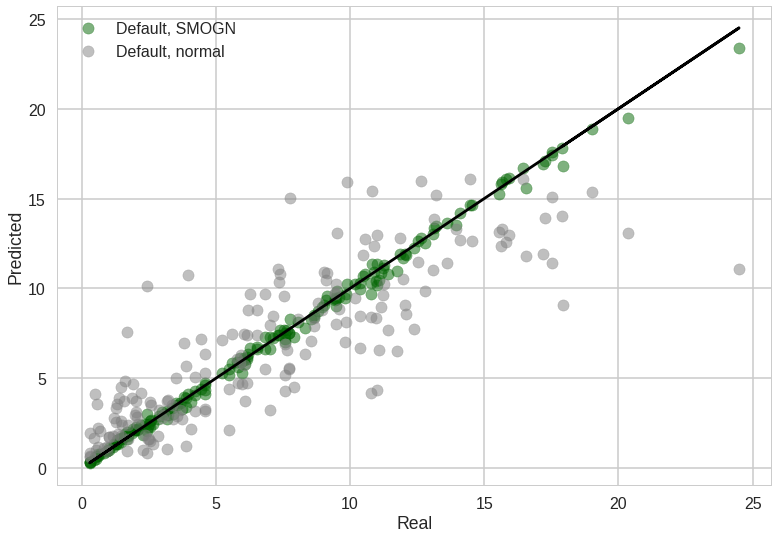

In [ ]:
predictions_def = np.load('/content/drive/MyDrive/Results/testing_versions/predictions_def_norm.npy')
real_def = np.load('/content/drive/MyDrive/Results/testing_versions/val_def_norm.npy')
predictions_def_smote = np.load('/content/drive/MyDrive/Results/testing_versions/predictions_def_smote.npy')
real_def_smote = np.load('/content/drive/MyDrive/Results/testing_versions/val_def_smote.npy')


plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
plt.scatter(real_def_smote, predictions_def_smote, label = 'Default, SMOGN', alpha=0.5, color='darkgreen')
plt.scatter(real_def, predictions_def, label = 'Default, normal', alpha=0.5, color='gray')

plt.plot(real_def, real_def, color='black')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.legend()
plt.savefig('/content/drive/MyDrive/Results/testing_versions/pred_vs_real.png', format='png', dpi=600)


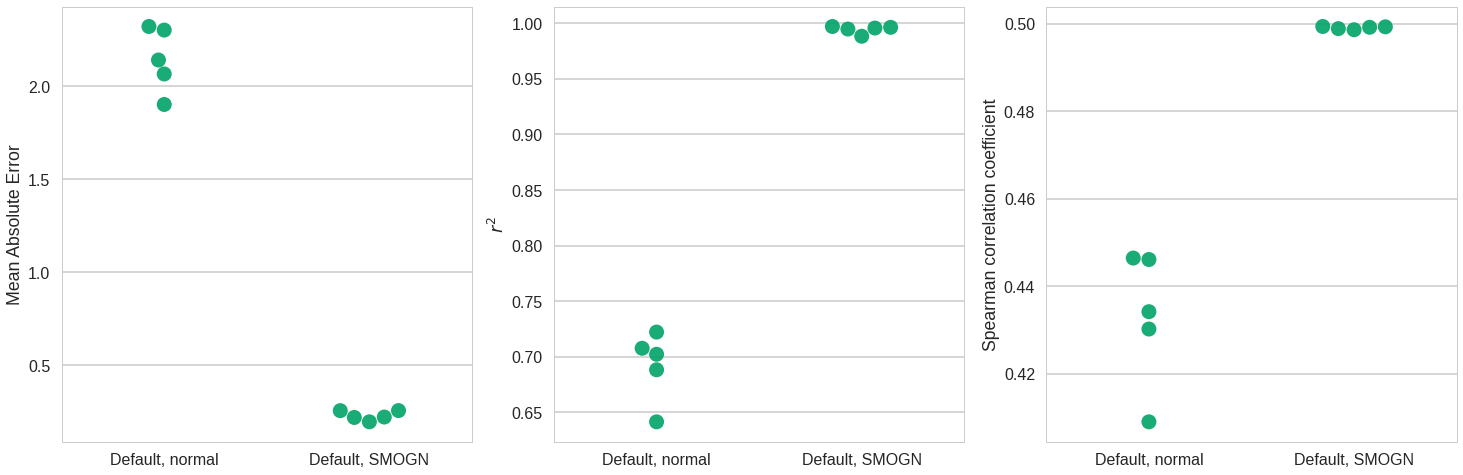

In [ ]:

def_norm = np.load("/content/drive/MyDrive/Results/testing_versions/maes_def_norm.npy")
def_smote = np.load("/content/drive/MyDrive/Results/testing_versions/maes_def_smote.npy")
results = [def_norm, def_smote] #, def_smote, dart_smote]

plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')

gs = gridspec.GridSpec(1,3)
fig = plt.figure(figsize=(25,8))

ax1 = fig.add_subplot(gs[0,0])
ax1 = sns.swarmplot(data=results, color='#00A368', alpha=0.9, size=15)
#ax = sns.violinplot(data=results, color='white', fliersize=0, linewidth=3, inner=None)
ax1.set_xticklabels(['Default, normal','Default, SMOGN'])
ax1.set_ylabel('Mean Absolute Error')
#plt.savefig('/content/drive/MyDrive/Results/testing_versions/maes.png', format='png', dpi=600)



def_norm = np.load("/content/drive/MyDrive/Results/testing_versions/r2_def_norm.npy")
def_smote = np.load("/content/drive/MyDrive/Results/testing_versions/r2_def_smote.npy")
results = [def_norm, def_smote] #, def_smote, dart_smote]

#fig, ax = plt.subplots(figsize=(10,10))
ax2 = fig.add_subplot(gs[0,1])
ax2 = sns.swarmplot(data=results, color='#00A368', alpha=0.9, size=15)
#ax = sns.violinplot(data=results, color='white', fliersize=0, linewidth=3, inner=None)
ax2.set_xticklabels(['Default, normal','Default, SMOGN'])
ax2.set_ylabel('$r^2$')
#plt.savefig('/content/drive/MyDrive/Results/testing_versions/r2.png', format='png', dpi=600)


def_norm = np.load("/content/drive/MyDrive/Results/testing_versions/sr_def_norm.npy")
def_smote = np.load("/content/drive/MyDrive/Results/testing_versions/sr_def_smote.npy")
results = [def_norm, def_smote] #, def_smote, dart_smote]

ax3 = fig.add_subplot(gs[0,2])
ax3 = sns.swarmplot(data=results, color='#00A368', alpha=0.9, size=15)
#ax = sns.violinplot(data=results, color='white', fliersize=0, linewidth=3, inner=None)
ax3.set_xticklabels(['Default, normal','Default, SMOGN'])
ax3.set_ylabel('Spearman correlation coefficient')
plt.savefig('/content/drive/MyDrive/Results/testing_versions/metrics_SMOGN.png', format='png', dpi=600)

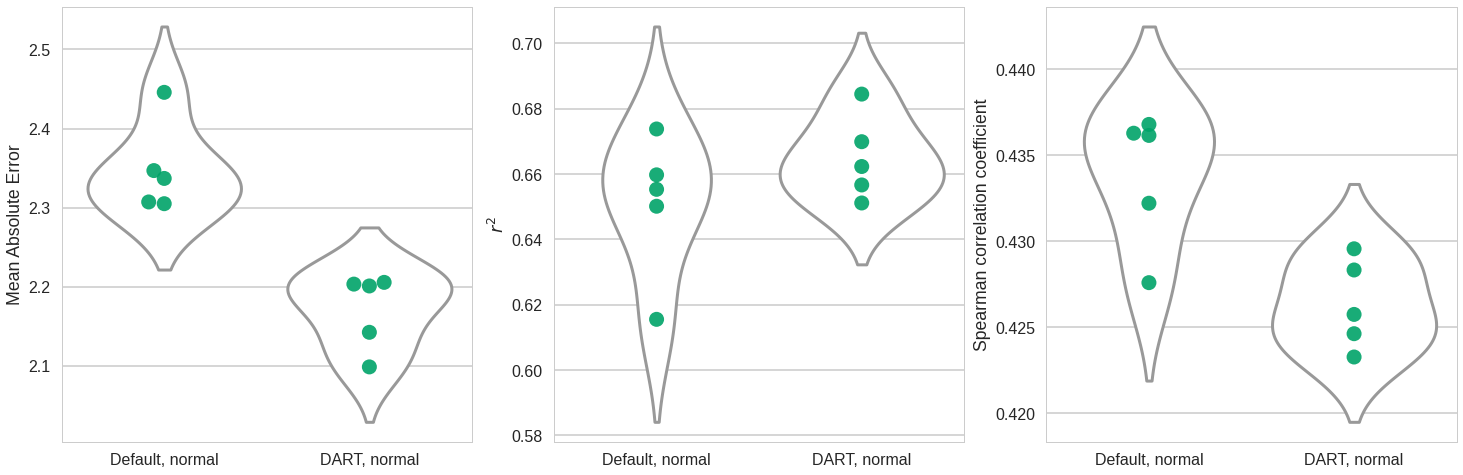

In [ ]:
dart_norm = np.load("/content/drive/MyDrive/Results/small_subsample/maes_dart_norm.npy")
def_norm = np.load("/content/drive/MyDrive/Results/small_subsample/maes_def_norm.npy")
results = [def_norm, dart_norm]

plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')

gs = gridspec.GridSpec(1,3)
fig = plt.figure(figsize=(25,8))

ax1 = fig.add_subplot(gs[0,0])
ax1 = sns.swarmplot(data=results, color='#00A368', alpha=0.9, size=15)
ax1 = sns.violinplot(data=results, color='white', fliersize=0, linewidth=3, inner=None)
ax1.set_xticklabels(['Default, normal', 'DART, normal'])
ax1.set_ylabel('Mean Absolute Error')


dart_norm = np.load("/content/drive/MyDrive/Results/small_subsample/r2_dart_norm.npy")
def_norm = np.load("/content/drive/MyDrive/Results/small_subsample/r2_def_norm.npy")
results = [def_norm, dart_norm]

ax2 = fig.add_subplot(gs[0,1])
ax2 = sns.swarmplot(data=results, color='#00A368', alpha=0.9, size=15)
ax2 = sns.violinplot(data=results, color='white', fliersize=0, linewidth=3, inner=None)
ax2.set_xticklabels(['Default, normal', 'DART, normal'])
ax2.set_ylabel('$r^2$')


dart_norm = np.load("/content/drive/MyDrive/Results/small_subsample/sr_dart_norm.npy")
def_norm = np.load("/content/drive/MyDrive/Results/small_subsample/sr_def_norm.npy")
results = [def_norm, dart_norm]

ax3 = fig.add_subplot(gs[0,2])
ax3 = sns.swarmplot(data=results, color='#00A368', alpha=0.9, size=15)
ax3 = sns.violinplot(data=results, color='white', fliersize=0, linewidth=3, inner=None)
ax3.set_xticklabels(['Default, normal', 'DART, normal'])
ax3.set_ylabel('Spearman correlation coefficient')
plt.savefig('/content/drive/MyDrive/Results/small_subsample/metrics_dart.png', format='png', dpi=600)


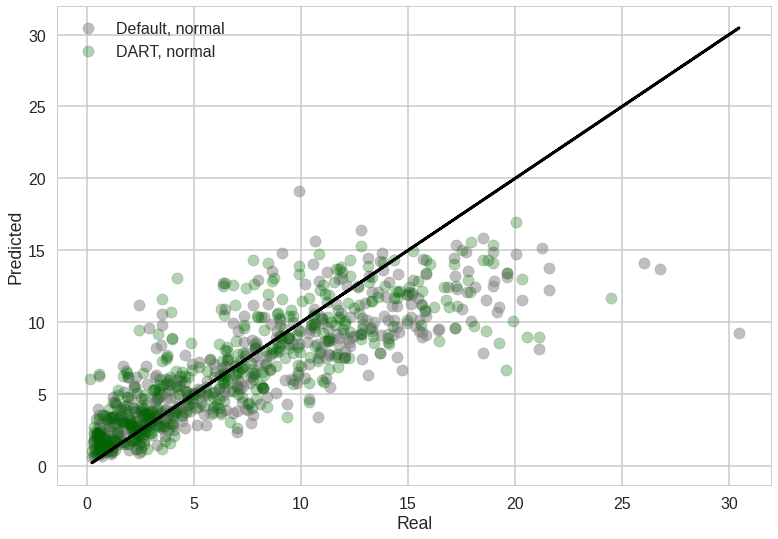

In [ ]:
predictions_def = np.load('/content/drive/MyDrive/Results/small_subsample/predictions_def_norm.npy')
real_def = np.load('/content/drive/MyDrive/Results/small_subsample/val_def_norm.npy')
predictions_dart = np.load('/content/drive/MyDrive/Results/small_subsample/predictions_dart_norm.npy')
real_dart_norm = np.load('/content/drive/MyDrive/Results/small_subsample/val_dart_norm.npy')


plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
plt.scatter(real_def, predictions_def, label = 'Default, normal', alpha=0.5, color='gray')
plt.scatter(real_dart_norm, predictions_dart, label = 'DART, normal', alpha=0.3, color='darkgreen')

plt.plot(real_def, real_def, color='black')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.legend()
plt.savefig('/content/drive/MyDrive/Results/small_subsample/pred_vs_real.png', format='png', dpi=600)